In [38]:
% matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn import linear_model
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# Social media usage reveals how small businesses recover after natural disasters in urban areas

#### Robert Eyre, Flavia De Luca, Filippo Simini

The challenge of nowcasting the effect of natural disasters (e.g. earthquakes, floods, hurricanes) on assets,
people and society is of primary importance for assessing the ability of such systems to recover from extreme events. Traditional
disaster recovery estimates, such as surveys and interviews, are usually costly, time consuming and do not scale. Here we
present a methodology to indirectly estimate the post-emergency recovery status (‘downtime’) of small businesses in urban
areas looking at their online posting activity on social media. Analysing the time series of posts before and after an event, we
quantify the downtime of small businesses for three natural disasters occurred in Nepal, Puerto Rico and Mexico. A convenient
and reliable method for nowcasting the post-emergency recovery status of economic activities could help local governments
and decision makers to better target their interventions and distribute the available resources more effectively.

# Load data

Load anonymous post data (businesses_id's have been randomised, posting day has been altered by +/- 3 days, and hour, minutes, seconds have been removed).

In [40]:
# Gorkha Earthquake
event_date = pd.to_datetime('2015-04-25')
posts = pd.read_csv('./data/post_data_k.csv.zip', parse_dates=['date'])

# # Hurricane Maria
# event_date = pd.to_datetime("2017-09-20")
# posts = pd.read_csv('./data/post_data_pr.csv.zip', parse_dates=['date'])

# # Chiapas Earthquake
# event_date = pd.to_datetime('2017-09-07')
# posts = pd.read_csv('./data/post_data_c.csv.zip', parse_dates=['date'])

In [41]:
posts = posts[posts.date >= '2013-01-01']
posts = posts[posts.date < '2018-05-01']

In [42]:
posts.head()

,date,b_id
0,2018-01-15,2158
1,2018-01-02,2158
2,2017-12-14,2158
3,2017-12-15,2158
4,2017-11-14,2158


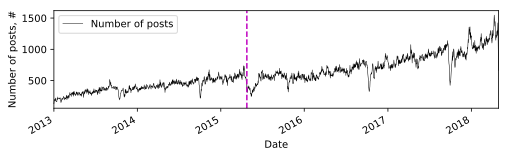

In [43]:
posts.date.value_counts().plot(figsize=[8, 2], lw = 0.5, c = 'k', label = 'Number of posts', legend = True)
plt.axvline(event_date, c = 'm', ls = '--')
plt.xlabel('Date')
plt.ylabel('Number of posts, #')

plt.show()

**Total number of posts made by businesses on Facebook in the selected region.** The date of the event is shown with a dashed magenta line.

# Step 1: Probability integral transform (PIT)

Firstly, we transform the posting data of each businesses to its respective 'mid-quantiles' series.

$x_i(t) \xrightarrow{\text{compute 'mid-quantiles'}}{} q_i(t)$

We then take the sum of all $q_i(t)$, $r_{PIT}(t)$, to form an aggregate time series of mid-quantiles in the region.

In this step we also compute the number of active businesses, $n(t)$, defining a business as active between its first and most recent post.

In [44]:
# Parameter used to detect in realtime
realtime_days = 3

In [45]:
def PIT(posts):

    # Data range for posts that we are looking at.
    start, end = (
        posts["date"].min(),
        posts["date"].max() + pd.Timedelta("{} day".format(realtime_days)),
    )
    dr = pd.date_range(start, end, freq="D")

    # Create list to store PIT vals.
    pit_array = []

    # Store for estimate of active businesses.
    num_active = pd.Series(0, index=dr)

    # Look at each business seperately.
    businesses = posts.groupby("b_id")

    for i, (_id, b) in enumerate(businesses):

        if int(len(businesses) / 100) != 0:
            if i % int(len(businesses) / 100) == 0:
                print(
                    "\r", "  Progress: ", np.ceil(100 * i / len(businesses)), end="%",
                )

        # Get number of posts made each day by business b
        b_posts = b["date"].value_counts()

        # Reindex so we count the days with no posts
        b_start, b_end = (
            b_posts.index.min(),
            b_posts.index.max() + pd.Timedelta("{} day".format(realtime_days)),
        )
        idx = pd.date_range(b_start, b_end)
        b_posts = b_posts.reindex(idx, fill_value=0)

        # Update the estimate for the number of active businesses.
        # We just store the start and end dates, we can then call
        # .cumsum later on to get the running number of active businesses.
        num_active.at[b_start] += 1
        if b_end + pd.Timedelta("{} day".format(realtime_days)) <= end:
            num_active.at[b_end + pd.Timedelta("{} day".format(realtime_days))] -= 1

        # Split the business into multiple parts
        # We assume that a business changes
        # its habits over time.
        chunks = enumerate(np.array_split(b_posts, max(1, len(b_posts) / 365),))

        # For each chunk, compute the PIT, add to the list.
        for k, chunk in chunks:
            ecdf = ECDF(chunk)
            pit_vals = (ecdf(chunk) + ecdf(chunk - 1)) / 2
            pit_array.append(pd.Series(pit_vals, index=chunk.index,))

    # Create aggregate dataframe.
    pit_array = pd.concat(pit_array)
    aggregate_df = pit_array.groupby(pit_array.index).sum()[:-realtime_days]

    # Get number of active businesses on a given day.
    num_active = num_active.cumsum()[:-realtime_days]
    return aggregate_df, num_active

In [46]:
aggregate_df, num_active = PIT(posts)

   Progress:  100.0%

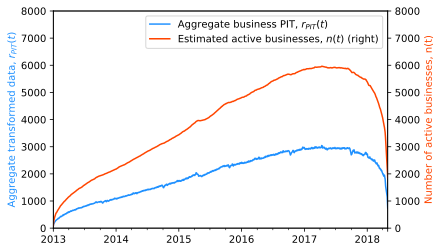

In [47]:
aggregate_df.plot(label = 'Aggregate business PIT, $r_{PIT}(t)$', c = 'dodgerblue', legend = True)
plt.ylabel(r'Aggregate transformed data, $r_{PIT}(t)$', color = 'dodgerblue')
plt.gca().set_ylim(0, 8000)

num_active.plot(secondary_y=True, label = 'Estimated active businesses, $n(t)$', c = 'orangered', legend = True)
plt.ylabel('Number of active businesses, n(t)', color='orangered')
plt.gca().set_ylim(0, 8000)

plt.show()

**Aggregate PIT data, $r_{PIT}(t)$, plotted with active business estimate, $n(t)$**. The series $r_{PIT}$ is equal to the sum of all $q_i(t)$ computed in the first step of the framework.

# Step 2: Apply Irwin Hall

The aggregate time series $r_{PIT}$ is transformed by a shifting and rescaling so that the mean is zeroed and the variance is one ($\tilde r_N(t)$). The probability integral transform is then applied to form a final transformed time series $r_U(t)$ for the level of activity in the region.

In [48]:
def IH(aggregate_df, num_active, date=None):
    def remove_linear_trend(detr_df0):

        detr_df0 = detr_df0.dropna()

        y = detr_df0.loc[:date].rolling(14).mean().dropna().values
        x = np.arange(len(y))

        model = linear_model.LinearRegression(fit_intercept=True)
        model.fit([[xx] for xx in x[:]], y[:])

        yf = model.coef_ * np.arange(len(detr_df0.values)) + model.intercept_

        detr_df0_m = pd.Series(detr_df0.values - yf, index=detr_df0.index)

        return detr_df0_m

    IH_m0 = aggregate_df - (num_active / 2)

    IH_m0_v1 = IH_m0 / np.sqrt(num_active / 12)

    IH_m0_v1 = remove_linear_trend(IH_m0_v1)

    IH_m0_vu = IH_m0_v1 / (IH_m0_v1.std())

    ih = lambda row: stats.norm.cdf(row, loc=0.0, scale=1.0)

    ih = IH_m0_vu.apply(ih)

    return ih

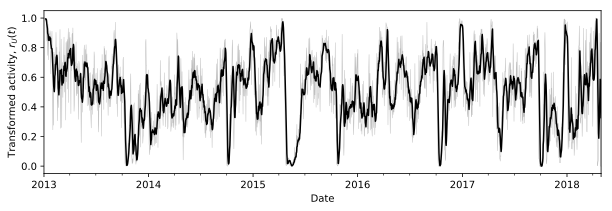

In [49]:
fig, ax = plt.subplots()

ih = IH(aggregate_df, num_active)

ih.plot(figsize=[8, 2], c = 'k', lw = 0.5, alpha = 0.25)
ih.rolling(7).mean().plot(figsize=[10, 3], c = 'k')

plt.xlabel('Date')
plt.ylabel(r'Transformed activity, $r_U(t)$')

plt.show()

The final signal $r_U(t)$ is shown. 

# Step 3: Event detection

We define an _event_ as a period of time when the weekly mean of $r_U(t)$ is below a given threshold value, $T$, for more than 7 consecutive days. 
The value of the threshold is set using a method aimed at detecting all periods when posting activity is significantly below the characteristic range of normal activity fluctuations. This value is found using the following 'elbow method'. 

In [50]:
def find_threshold(ih, ax=None):

    ih = ih.rolling(7).mean()

    prec = 500
    min_thresh = 0
    max_thresh = 1

    # We test all possible thresholds at once, by  making multiple copies of our input signal.
    b = pd.concat([ih] * prec, axis=1)

    # For each possible threshold value, see where the input signal is below this threshold.
    s = b < np.linspace(min_thresh, max_thresh, prec)

    # For each possible threshold, we then look at how many events (durations under the threshold) are found.
    # One way to do this is XOR s with itself, but shifted by one to find the start and end points of each event.
    events = s ^ s.shift(1)
    # As we care about the number of events, we only need to know when each event starts, so we can divide the number we get by 2.
    events = (events.sum(axis=0) / 2).apply(int)

    # We don't want to set the threshold too low - when using the angle method described in the manuscript,
    # we occasionally get a very small angle due to the shape of the curve. By setting the first value of
    # the events count to the maximum value in the first 10% of the curve, we stop this from happening.
    events.iat[0] = events.iloc[0 : int(prec / 10)].max()
    events.index = np.linspace(min_thresh, max_thresh, prec)

    # Find point that gives maximal angle using trigonometry.
    k = np.arctan((events - events.iloc[0]) / (events.index - events.index[0]))

    # Fit line from [0,0] to [idxmax, max], find maximal difference from this line and set as elbow point.
    p = np.poly1d([events.loc[k.idxmax()] / k.idxmax(), 0])
    t = (p(events[: k.idxmax()].index) - events[: k.idxmax()].values).argmax()
    tx = events.index[t]

    # Plot number of events vs threshold
    if ax:
        events.iat[0] = 0
        events.plot(label="$y = f(T)$", c="k", ax=ax)
        ax.scatter(k.idxmax(), events.loc[k.idxmax()])
        ax.plot(
            events[: events.idxmax()].index,
            p(events[: events.idxmax()].index),
            label=r"$y = \theta T$",
            ls=":",
            c="k",
        )
        ax.plot(
            [events.index[t], events.index[t]],
            [events.iloc[t], p(events.index[t])],
            ls="--",
            c="r",
            label=r"$\max[f(\theta) - f(T)]$",
        )
        ax.legend(loc=4)
        ax.set_xlabel(r'Threshold, $T$')
        ax.set_ylabel(r"Number of event, $f(T)$")

    return tx, events

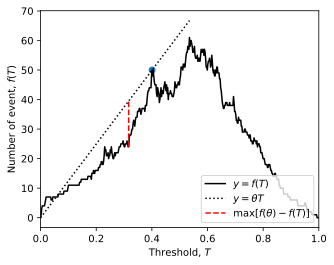

In [51]:
fig, ax = plt.subplots(figsize = [5, 4])

threshold, events_per_threshold = find_threshold(ih, ax=ax)

plt.show()

**Elbow detection**. First, the number of potential downtime events are recorded at multiple threshold values; the number of events for a given threshold value is denoted as f(T). Second, we identify the threshold value, $T^{*}$, at which the number of events begins to rapidly rise. This point marks the transition between the size of activity fluctuations due to anomalous events andthe characteristic size of normal activity fluctuations.

In [52]:
def get_event(ih, threshold, date, all_events=False):

    ih = ih.rolling(7).mean()

    # Find the points below the threshold
    df = (ih < threshold).apply(int)
    
    # Turn thi
    lst = [g for (_, g) in df.groupby((df.diff() != 0).cumsum()) if sum(g) > 0]

    if all_events:
        return list(zip(lst, map(len, lst)))

    for e in lst:
        if date in e or (
            pd.to_datetime(date) < e.index.max()
            and pd.to_datetime(date) > e.index.min() - pd.Timedelta("7 days")
        ):
            return e, len(e)

    return 0, 0

In [53]:
events = get_event(ih, threshold, event_date, all_events=True)

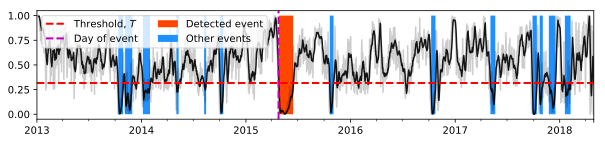

In [55]:
fig, ax = plt.subplots(figsize=[10, 2])

ih.plot(c="k", alpha=0.2, label = "")
ih.rolling(7).mean().plot(c="k", alpha=0.9, label = "")

for e in events:
    if len(e[0]) > 30:
        plt.fill_between(e[0].index.values, 0, 1, facecolor="orangered")
    elif len(e[0]) > 7:
        plt.fill_between(e[0].index.values, 0, 1, facecolor="dodgerblue")
        
ax.axhline(threshold, ls = '--', c = 'r', lw = 2)
ax.axvline(event_date, ls = '--', c = 'm', lw = 2)

legend_elements = [Line2D([0], [0], ls = '--', c = 'r', lw = 2, label = 'Threshold, $T$'),
                   Line2D([0], [0], ls = '--', c = 'm', lw = 2, label = 'Day of event'),
                   Patch(facecolor = 'orangered', label = 'Detected event'),
                   Patch(facecolor = 'dodgerblue', label = 'Other events')]

plt.legend(handles = legend_elements, ncol = 2, loc = 'upper left')

plt.show()

**Downtime events longer than seven days detected in the selected region**. Transformed posting activity data, $r_U(t)$, is shown in grey, its one week rolling mean is shown in black and the thresholds $T^{\ast}$ estimated with the 'elbow method' are marked with dashed horizontal red lines. The detected periods of downtime are highlighted with  vertical red bars (the natural hazard related event) and blue bars (other events). The date of the event in each region is marked by a dashed vertical magenta line.

In [56]:
# Find the downtime event.
downtime_event, downtime_length = get_event(ih, threshold, event_date)

In [57]:
print(downtime_length)

50


# Realtime simulation

The proposed system can be applied in real-time giving estimates of the recovery status during the weeks immediately after an event. 
We simulate the collection of data in real time by cropping our data in the weeks following the event
and we calculate $d_{\rm RT}(t)$, the real-time estimate of the downtime $t$ weeks after the event, using just the posts published until week $t$.

In [134]:
downtimes = []

for _, cutoff in enumerate(
    sorted(pd.date_range(event_date - pd.Timedelta('14 days'), event_date + pd.Timedelta("100 days"), freq="7D"))
):

    # Apply PIT
    detr, num_act = PIT(posts[posts.date < cutoff])

    # Apply IH
    ih = IH(detr, num_act, event_date)

    # Event detection
    threshold, _ = find_threshold(ih)

    # Get all events
    all_events = get_event(ih, threshold, event_date)
    
    # Store [cutoff_date, ideal_downtime, detected_downtime]
    downtimes.append(
        [cutoff, max(0, min((cutoff - event_date).days, downtime_length)), all_events[1]]
    )

   Progress:  100.0%

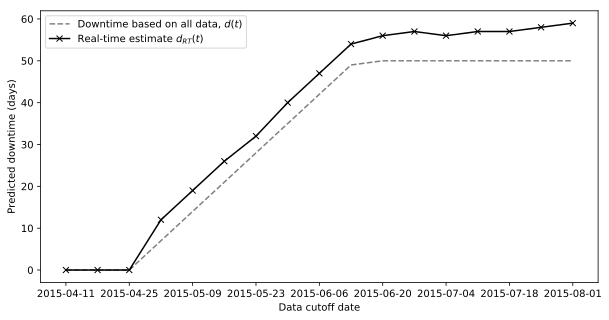

In [145]:
fig = plt.figure(figsize=[10, 5])

cutoff_date, ideal_downtime, detected_downtime = zip(*downtimes)

plt.plot(cutoff_date, ideal_downtime, ls="--", c="k", alpha=0.5, label="Downtime based on all data, $d(t)$")
plt.plot(cutoff_date, detected_downtime, marker="x", c="k", label="Real-time estimate $d_{RT}(t)$")

plt.xlabel("Data cutoff date")
plt.ylabel("Predicted downtime (days)")

plt.legend()

plt.gca().set_xticks(ticks = pd.date_range(event_date - pd.Timedelta('14 days'), event_date + pd.Timedelta('100 days'), freq='14D'))
plt.gca().set_xticklabels(labels = pd.date_range(event_date - pd.Timedelta('14 days'), event_date + pd.Timedelta('100 days'), freq='14D').date)

plt.show()

**Downtime estimation in realtime**. We plot the estimate found when consider data only up to each data cutoff point.